# 谱聚类

## 1. 基础概念

#### 1.1 什么是聚类

将多维空间中的样本分为多个组，使得组内的样本尽可能相似，组间样本尽可能不同。有K-means，谱聚类，DBSCAN等多种聚类算法。

#### 1.2 什么是谱聚类

谱聚类是图论演变而来的聚类算法。将所有样本点\\(v\\)视为图的顶点，并使用邻接矩阵\\(W\\)表示图，矩阵中的每一个元素\\(w_{ij}\\)表示边的权重。当\\(v_i\\)到\\(v_j\\)的边不存在的时候，\\(w_{ij}\\)的值取一个非常小，趋近或等于0的值；当\\(v_i\\)到\\(v_j\\)的邻接非常紧密，\\(w_{ij}\\)的值取一个相对较大的值。

对于n维空间内，一个有m个顶点的图，它的顶点组成矩阵：

$$V=
 \left[
 \begin{matrix}
   v_{11} & v_{12} & ... & v_{1n} \\
   v_{21} & v_{22} & ... & v_{2n} \\
   ... & ...  & ... & ... \\
   v_{m1} & v_{m2}  & ... & v_{mn}
  \end{matrix}
  \right]
$$

这样的图，它的邻接矩阵是一个\\(m\times m\\)矩阵：

$$W=
 \left[
 \begin{matrix}
   w_{11} & w_{12} & ... & w_{1m} \\
   w_{21} & w_{22} & ... & w_{2m} \\
   ... & ...  & ... & ... \\
   w_{m1} & w_{m2}  & ... & w_{mm}
  \end{matrix}
  \right]
$$

之后，谱聚类算法将这样的图切分成k个子图，使得子图间的权重尽可能小，子图内的权重尽可能大。而这k个子图就是聚类生成的k个类。

## 2. 如何度量样本间的相似程度

K-means算法使用欧式距离度量样本间的相似，距离越小相似程度越大。
而谱聚类使用边的权重度量样本的相似程度，权重越大相似程度越大。

#### 2.1 高斯核函数

谱聚类的相似度量方式有很多，通常使用高斯核函数RBF将欧式距离转换为权重，以度量相似程度。
举一个简单的例子，假设空间中有10个顶点如下图所示：

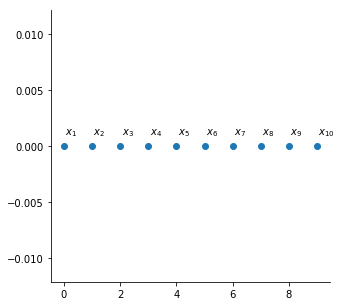

In [13]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 10, 1)
y = np.zeros(x.shape)

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)

ax.scatter(x, y)
for i in range(10):
    ax.annotate('$x_{%d}$' % (i+1), xy=(x[i], y[i]), xytext=(x[i]+0.05, y[i]+0.001))

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

对于\\(x_6\\)来说，要使距离它越近的点与它组成的边权重越大，可以使用RBF将其它点与它之间的欧式距离进行映射，得到与\\(x_6\\)相连的所有边的权重\\(w_{6j}\\)结果如下图所示：

e:\py3-projects\graphml\venv\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  if __name__ == '__main__':


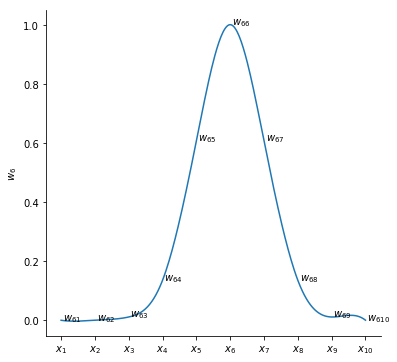

In [2]:

fig, rbf = plt.subplots()
fig.set_size_inches(6, 6)

x1 = [np.exp(-np.square(x[i]-x[5])/2) for i in range(10)]

xi = np.linspace(x.min(),x.max(),300)
from scipy.interpolate import spline
yi = spline(x,x1,xi)

rbf.plot( xi, yi )
for i in range(10):
    rbf.annotate('$w_{6%d}$' % (i+1), xy=(x[i], x1[i]), xytext=(x[i]+0.05, x1[i]+0.001))
rbf.spines['right'].set_visible(False)
rbf.spines['top'].set_visible(False)

rbf.set_xticks([i for i in range(10)])
rbf.set_xticklabels(['$x_{%d}$' % (i+1) for i in range(10)])

rbf.set_ylabel('$w_6$')
plt.show()

可以看出距离\\(x_6\\)越近的点与\\(x_6\\)组成的边，权重越大。

#### 2.2 K近邻法

除此之外，还可以使用K近邻法度量相似程度，对于某个顶点，找出距离它最近的k个顶点，这k个顶点的权重设为1，其它的权重设为0。

高斯核函数和K近邻法在scikit-learn的[谱聚类算法](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering)都已经被支持，在本文最终的例子中，使用K近邻法作用相似程度度量方法计算邻接矩阵。

## 3. 谱聚类的优化目标

谱聚类的目标是聚类之后，子图间权重尽可能小，子图内权重尽可能大。可以用\\(A_1,A_2,...,A_k\\)表示聚类之后得到k个组，即k个子图。对于某个子图$A_i$，它与其它子图\\(\overline{A_i}\\)之间没有边连接。

对于两个子图A和B，定义A与B间的权重：
$$W(A, B)=\sum \limits_{i \in A, j \in B} w_{ij}$$
则$A_i$与其他子图间的权重为：
$$W(A_i, \bar{A_i})$$
那么$A_i$组内的权重如何表示呢？

对于一个样本$x_i$，可以定义度\\(d_i=\sum \limits_{j=1}^m w_{ij}\\)。可以得到度矩阵：

$$D=
 \left[
 \begin{matrix}
   d_{1} & 0 & ... & 0 \\
   0 & d_{2} & ... & 0 \\
   ... & ...  & ... & ... \\
   0 & 0 & ... & d_m
  \end{matrix}
  \right]
$$

对于子图$A_i$，组内的权重可以表示为：
$$vol(A_i)=\sum \limits_{i \in A_i} d_{i}$$

我们希望，$A_i$图内权重尽可能大，并且与其它图之间的权重尽可能小，即优化目标为：

$$min\frac{W(A_i, \bar{A_i})}{vol(A_i)}$$

以子图$A_k$为例：

$$
\frac{W(A_k, \bar{A_k})}{vol(A_k)}=\frac{1}{2} (\frac{W(A_k, \bar{A_k})}{vol(A_k)}+\frac{W(\bar{A_k}, A_k)}{vol(A_k)})
$$

$$
=\frac{1}{2} (\sum \limits_{i \in A_k, j \in \bar{A_k}} \frac{w_{ij}}{vol(A_k)}+\sum \limits_{i \in \bar{A_k}, j \in A_k} \frac{w_{ij}}{vol(A_k)})
$$

$$
=\frac{1}{2} (\sum \limits_{i \in A_k, j \in \bar{A_k}} w_{ij}(\frac{1}{\sqrt{vol(A_k)}}-0)^2+\sum \limits_{i \in \bar{A_k}, j \in A_k} w_{ij}(\frac{1}{\sqrt{vol(A_k)}}-0)^2)
$$

为了将\\(i \in A_k与j \in \bar{A_k}\\)的形式统一起来，可以定义一个指示m行列向量$h_k$。$h_k$的第i行为：

$$
h_{ik}=\left\{
\begin{aligned}
0 &  & v_i \notin A_k \\
\frac{1}{\sqrt{vol(A_k)}} &  & v_i \in A_k
\end{aligned}
\right.
$$

代入可得：

$$
\frac{W(A_k, \bar{A_k})}{vol(A_k)}=\frac{1}{2} (\sum \limits_{i \in A_k, j \in \bar{A_k}} w_{ij}(h_{ik}-h_{jk})^2+\sum \limits_{i \in \bar{A_k}, j \in A_k} w_{ij}(h_{ik}-h_{jk})^2)
$$


$$
=\frac{1}{2} (\sum \limits_{i \in A_k, j \in \bar{A_k}} w_{ij}(h_{ik}-h_{jk})^2+0+0+\sum \limits_{i \in \bar{A_k}, j \in A_k} w_{ij}(h_{ik}-h_{jk})^2)
$$


$$
=\frac{1}{2} (\sum \limits_{i \in A_k, j \in \bar{A_k}} w_{ij}(h_{ik}-h_{jk})^2+\sum \limits_{i \in A_k, j \in A_k} w_{ij}(h_{ik}-h_{jk})^2+\sum \limits_{i \notin A_k, j \notin A_k} w_{ij}(h_{ik}-h_{jk})^2+\sum \limits_{i \in \bar{A_k}, j \in A_k} w_{ij}(h_{ik}-h_{jk})^2)
$$

$$
=\frac{1}{2} (\sum \limits_{i =1 }^m \sum \limits_{j = 1}^m w_{ij}(h_{ik}-h_{jk})^2)
$$

$$
=\frac{1}{2} (\sum \limits_{i =1 }^m \sum \limits_{j = 1}^m w_{ij}(h_{ik}^2-2h_{ik}h_{jk}+h_{jk}^2))
$$

$$
=\frac{1}{2} (\sum \limits_{i =1 }^m \sum \limits_{j = 1}^m w_{ij}(h_{ik}^2)-2\sum \limits_{i =1 }^m \sum \limits_{j = 1}^m w_{ij}h_{ik}h_{jk}+\sum \limits_{i =1 }^m \sum \limits_{j = 1}^m w_{ij}h_{jk}^2))
$$

$$
=\frac{1}{2} (\sum \limits_{i =1 }^m h_{ik}^2 d_i-2\sum \limits_{i =1 }^m \sum \limits_{j = 1}^m w_{ij}h_{ik}h_{jk}+\sum \limits_{j =1 }^m h_{jk}^2 d_j))
$$

$$
=\sum \limits_{i =1 }^m h_{ik}^2 d_i-\sum \limits_{i =1 }^m \sum \limits_{j = 1}^m w_{ij}h_{ik}h_{jk}
$$

$$
=h_k^T D h_k-h_k^T W h_k
$$

$$
=h_k^T (D-W) h_k
$$

令L=D-W，L就是有名的拉普拉斯矩阵，那么


$$
\frac{W(A_k, \bar{A_k})}{vol(A_k)}=h_k^T L h_k
$$

对k个子图的优化目标进行求和，那么对于整个图，优化目标可以表示为

$$
Ncut(A_1,A_2,...A_k)= \frac{1}{2} \sum \limits_{i=1}^k \frac{W(A_i, \bar{A_i})}{vol(A_i)}
$$

$$
= \sum \limits_{i=1}^k h_k^T L h_k
$$

于是我们对于整张图，我们的优化目标变成了：

$$min \sum \limits_{i=1}^k h_k^T L h_k$$

$$=min  \ tr(H^T L H) $$

考虑到指示向量h与度d的定义，可以得到：

$$H^T D H = I $$

而这个式子很眼熟，与主成分分析PAC的优化目标仅仅的差异在于约束条件多了一个D。那么现在想办法把差异的部分去掉。

令\\(F=D^\frac{1}{2}H\\)，那么\\(H = D^\frac{-1}{2} F\\)。那么优化目标以及约束条件变为：

$$min  \ tr(F^TD^\frac{-1}{2} L D^\frac{-1}{2} F) $$
$$ s.t.\ F^T F = I $$

把\\(D^\frac{-1}{2} L D^\frac{-1}{2}\\)看作一个整体，那么优化目标就与PAC的优化目标完全一样了，要求最小值，只需要找到矩阵\\(D^\frac{-1}{2} L D^\frac{-1}{2}\\)的k个最小的特征值就完成了。而这k个特征值对应的特征向量就组成了\\(m\times k\\)的矩阵F。F就是谱聚类中的“谱”，F的m个行向量对应图中的m个顶点。最终，我们使用传统的聚类算法将F的m个行向量进行聚类，就得到了最终的聚类结果。

## 4. 算法步骤总结

根据前面的分析，可以总结出，算法的步骤如下：

1. 计算出邻接矩阵W
2. 根据W，计算出度矩阵D
3. 根据D与W，计算出拉普拉斯矩阵L
4. 根据L与D，计算出B=\\(D^\frac{-1}{2} L D^\frac{-1}{2}\\)
5. 求出B最小的k个特征值对应的k个特征向量组成的矩阵F
6. 对F进行聚类（如k-means），得到最终的结果

## 5. 实例

以[scikit-learn众多聚类实例](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py)中的圆圈分类为例。有1500个样本，样本分布如图所示：

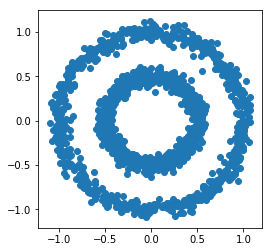

In [3]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)[0]

x1 = noisy_circles[:,0]
x2 = noisy_circles[:,1]

originX = np.array([x1, x2]).T

fig, ax = plt.subplots()
fig.set_size_inches(4, 4)

ax.scatter(x1, x2)

现在需要对数据集进行聚类。可以从分布图看出，样本聚集在2个同心圆上。所以，理想的分类结果应该是聚成2类，每个圆上的样本聚成1类。

按照谱聚类的步骤，我们先算出邻接矩阵W：

In [5]:
from sklearn.neighbors import kneighbors_graph

connectivity = kneighbors_graph(originX, n_neighbors=10, include_self=False, mode = 'distance')
W = 0.5 * (connectivity + connectivity.T)
W = W.toarray()

然后，利用邻接矩阵W，计算出度矩阵D：

In [6]:
D = np.zeros(W.shape)
for i in range(W.shape[0]):
    for j in range(W.shape[0]):
        D[i, i] = D[i, i]+W[i,j]

然后，可以使用W与D，计算出拉普拉斯矩阵L：

In [7]:
L = D-W

接着，计算出\\(D^\frac{-1}{2} L D^\frac{-1}{2}\\)，以B表示：

In [8]:
tmp = np.zeros(D.shape)
for i in range(tmp.shape[0]):
    tmp[i,i] = 1.0/np.sqrt(D[i,i])
B = tmp@L@tmp

for i in range(B.shape[0]):
    for j in range(B.shape[1]):
        B[i,j] = '%.9f'%(B[i,j])
        

然后，求出B的2（k=2）个最小的特征值，即这2个特征对应的特征向量组成的矩阵F：

In [9]:
from numpy.linalg import eig
eigenvalue,eigenvector=eig(B)

first = np.where(eigenvalue == np.min(eigenvalue))[0][0]
second = np.where(eigenvalue == np.max(eigenvalue))[0][0]
for i in range(eigenvalue.shape[0]):
    if i == first:
        continue;
    if eigenvalue[i]<eigenvalue[second]:
        second=i;
        
F = np.array([eigenvector[:,first], eigenvector[:,second]], np.float64).T

最后，实用kmeans对F中1500个样本进行聚类，结果如图所示：

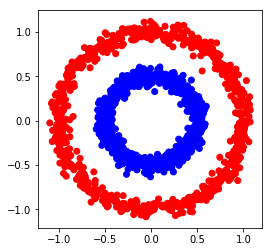

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(F)

colors = []
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 1:
        colors.append('red')
    else:
        colors.append('blue')
        
fig, ax = plt.subplots()
fig.set_size_inches(4, 4)

ax.scatter(x1, x2, c=colors, marker='o')

从图中可以看出，算法成功地将样本聚成2类，每一类分别聚集在2个圆上，与我们期待的结果一致。
实际上，scikit-learn已经封装好了算法的所有步骤，在实际使用的时候，只需要调用scikit-learn的SpectralClustering类就行了，以下是scikit-learn的计算方法，以及最终的聚类结果：

> e:\py3-projects\graphml\venv\lib\site-packages\sklearn\cluster\spectral.py(487)fit()
-> random_state = check_random_state(self.random_state)
(Pdb) c


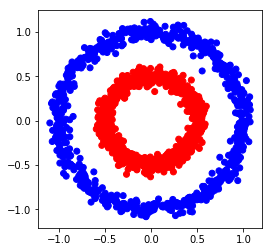

In [12]:
from sklearn.cluster import SpectralClustering

originX = StandardScaler().fit_transform(originX)
clustering = SpectralClustering(n_clusters=2,
        eigen_solver='arpack',
        affinity="nearest_neighbors").fit(originX)


colors = []
for i in range(clustering.labels_.shape[0]):
    if clustering.labels_[i] == 1:
        colors.append('red')
    else:
        colors.append('blue')
        
fig, ax = plt.subplots()
fig.set_size_inches(4, 4)

ax.scatter(x1, x2, c=colors, marker='o')